In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})

In [2]:
test = pd.read_csv('data/test.csv.gz')

X_train = pd.DataFrame(np.load('data/X_train.npz')['X_train'])
X_val = pd.DataFrame(np.load('data/X_val.npz')['X_val'])
y_train = pd.DataFrame(np.load('data/y_train.npz')['y_train'])
y_val = pd.DataFrame(np.load('data/y_val.npz')['y_val'])
test_new = pd.DataFrame(np.load('data/test_new.npz')['test_new'])

In [3]:
def rmse(*args):
    """ Funcion that calculates the root mean squared error"""
    return np.sqrt(mean_squared_error(*args))
def clip20(x):
    return np.clip(x, 0, 20)

Now that the model is trained and saved for later usage, what's left is simply submitting.

So, here I train the stacking model. Also I check how correlated are the predictions for the first level models (because this matters in stacking).

## Stacking

- **First Level models (Base models):** Light Gradient Boosting, XGBoost, Random Forest. These are used to build the 2-nd level **train-metafetures**.
- **Second Level models (Meta-model):** Linear Regression

### First level models

In [4]:
lgb_model = pickle.load(open('models/best_lgb.pkl', 'rb'))
xgb_model = pickle.load(open('models/best_xgb.pkl', 'rb'))
rf_model = pickle.load(open('models/best_rf.pkl', 'rb'))

I noticed that perfection in these metrics indicate obvious OVERFITTING. So 0.6 or even higher might be excellent for submission.

In [5]:
pred_lgb_val = lgb_model.predict(X_val)
print('Train RMSE for lgb is  %f' % rmse(clip20(y_train), clip20(lgb_model.predict(X_train))))
print('Val RMSE for lgb is %f' % rmse(clip20(y_val), clip20(pred_lgb_val)))

Train RMSE for lgb is  0.708548
Val RMSE for lgb is 0.573259


In [6]:
pred_xgb_val = xgb_model.predict(X_val)
print('Train RMSE for xgb is %f' % rmse(clip20(y_train), clip20(xgb_model.predict(X_train))))
print('Val RMSE for xgb is %f' % rmse(clip20(y_val), clip20(pred_xgb_val)))

Train RMSE for xgb is 0.903240
Val RMSE for xgb is 0.739043


In [7]:
pred_rf_val = rf_model.predict(X_val)
print('Train RMSE for rf is %f' % rmse(clip20(y_train), clip20(rf_model.predict(X_train))))
print('Val RMSE for rf is %f' % rmse(clip20(y_val), clip20(pred_rf_val)))

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished


Train RMSE for rf is 0.898301
Val RMSE for rf is 0.702159


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.4s finished


### Correlation

This is for checking how correlated are the preditions by the base models.

It is understandable that models have to be as different as possible.

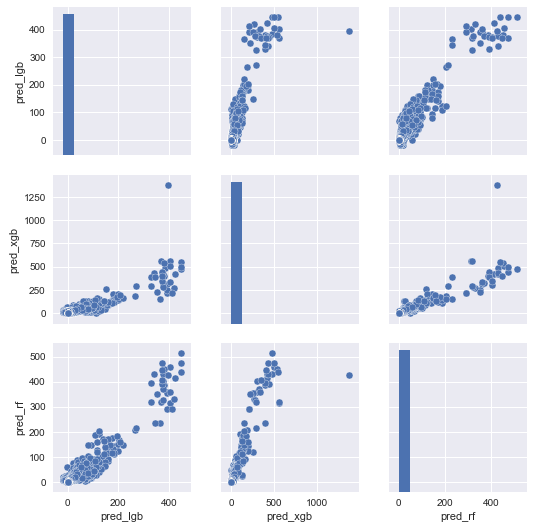

In [8]:
sns.pairplot(pd.DataFrame({'pred_lgb':np.nan_to_num(pred_lgb_val),
                           'pred_xgb':np.nan_to_num(pred_xgb_val),
                           'pred_rf':np.nan_to_num(pred_rf_val)}))

### Second level model

In [9]:
X_val_level2 = np.c_[pred_lgb_val, pred_xgb_val, pred_rf_val] 

In [10]:
lr = LinearRegression()
lr.fit(X_val_level2, y_val)

# This is the stacking part
pred_lr_val =  clip20(lr.predict(X_val_level2))

print('Test rmse for stacking variables is %f' % rmse(clip20(y_val), clip20(pred_lr_val)))

Test rmse for stacking variables is 0.739058


/Users/rgap/.virtualenvs/rgap-lectures/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


## Submission

We apply the same logic to the test data

In [11]:
pred_test_lgb = lgb_model.predict(test_new)
pred_test_xgb = xgb_model.predict(test_new)
pred_test_rf = rf_model.predict(test_new)
X_test_level2 = np.c_[pred_test_lgb, pred_test_xgb, pred_test_rf]
# X_test_level2 = np.c_[pred_test_xgb, pred_test_rf]
test_pred = clip20(lr.predict(X_test_level2))
test_pred.mean()

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished


0.15853159530931674

In [13]:
predictions = pd.DataFrame()
predictions['shop_id'] = test.shop_id
predictions['item_id'] = test.item_id
predictions['item_cnt_month'] = test_pred
submision = test[['ID', 'shop_id', 'item_id']].merge(predictions, on=['shop_id', 'item_id'], how='left')
submision[['ID', 'item_cnt_month']].to_csv('submission/submission.csv',index=False)